In [17]:
# This example is adopted from Geron's Hands-On Machine Learning with Scikit-Learn and Tensorflow
import pandas as pd
import os
import tarfile
from six.moves import urllib

HOUSING_PATH = "datasets/housing"

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [18]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [20]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [21]:
housing["ocean_proximity"].value_counts() #look for categories in this data

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [22]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


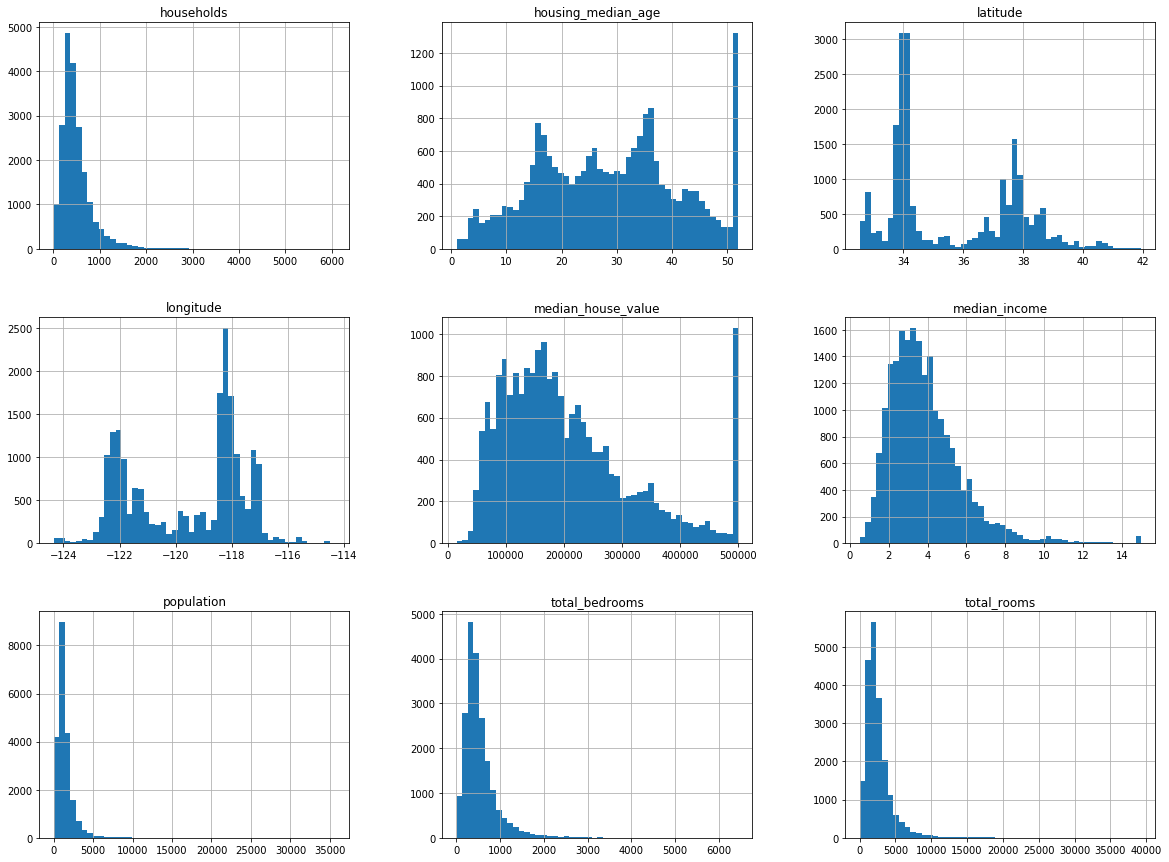

In [23]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [32]:
# Create a test set
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

#  We can also split datasets with consistent identifiers so later wheb we recieve an updated dataset,
#  we end up with a consistent test set.
import hashlib

# check the last byte of the hash and put the instance in the test set if this value is lower or equal to
# 20% 256 (20, because that 20=test_ratio)
def test_set_check(identifier, test_ratio, myhash):
    return myhash(np.int64(identifier)).digest()[-1]<256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, myhash = hashlib.md5):
    ids = data[id_column]
    in_test_set= ids.apply(lambda id_:test_set_check(id_, test_ratio, myhash))
    return data.loc[~in_test_set], data.loc[in_test_set]


#  now we can use stable features to build a unique identifier
housing_with_id = housing.reset_index() #adds an 'index' column
housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]


In [33]:
train_set, test_set = split_train_test_by_id(housing_with_id,0.2, "id") 

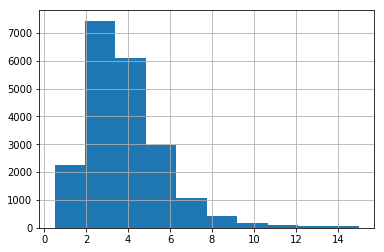

In [37]:
housing["median_income"].hist()
plt.show()

In [38]:
# this code creates an income category attribute by dividing the median income 
# by 1.5 and rouding up using the ceil function to create discrete categories and merging
# categories greater than 5
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace = True)

In [45]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

housing["income_cat"].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [46]:
# remove the income_cat to bring the data back to normal
for mySet in (strat_train_set, strat_test_set):
    mySet.drop(["income_cat"], axis=1, inplace=True)

In [47]:
housing = strat_test_set.copy()

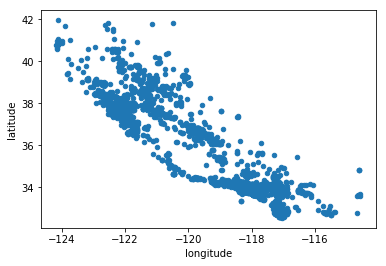

In [50]:
# Visualize the data with a scatter plat Latitude vs. Longitude
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

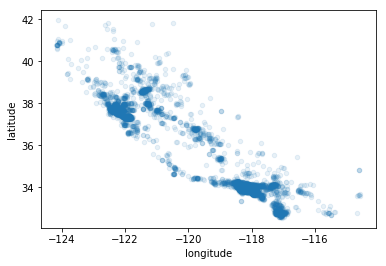

In [55]:
# playing with alpha will help us visualize places with high density of data points
housing.plot(kind="scatter",x="longitude",y="latitude", alpha=0.1)
plt.show()

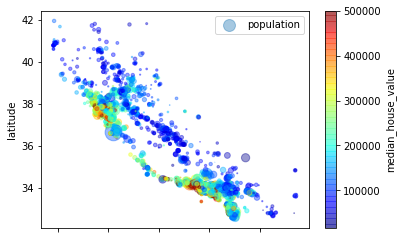

In [59]:
# The radius of each circle represents the district's population
# color represents the price
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
            s=housing["population"]/100, label="population", 
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            )
plt.legend()
plt.show()

In [61]:
corr_matrix = housing.corr()
# look at how each attribute correlates with the median house value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691831
total_rooms           0.131435
housing_median_age    0.071357
households            0.071242
total_bedrooms        0.057568
population           -0.016033
longitude            -0.039987
latitude             -0.150124
Name: median_house_value, dtype: float64

/Users/hamzakhan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """


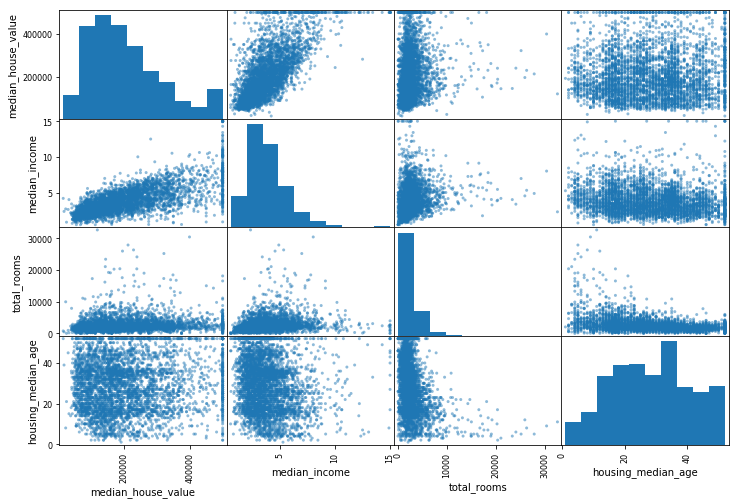

In [66]:
# Panda's scatter_matrix function: plots every numerical attribute against every other numerical attribute
# 11 attributes will give you 121 (11^2) plots
from pandas.tools.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

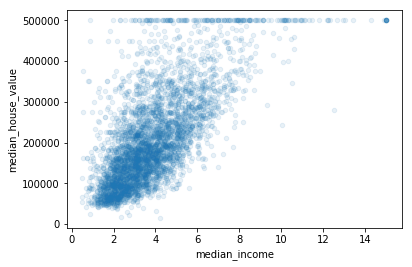

In [69]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()